In [ ]:
! pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 14.9 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Draw, PandasTools

In [ ]:
molecules = pd.read_csv("/content/output_file_first_step.csv", index_col=0)
print(molecules.shape)
molecules.head()

(3134, 6)


,molecule_chembl_id,IC50,units,smiles,pIC50,class
0,CHEMBL281957,0.4,nM,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,9.397940,active
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive
2,CHEMBL377085,4100.0,nM,Cc1cc(C)c2c(N)c(C(N)=O)sc2n1,5.387216,intermediate
3,CHEMBL209148,4100.0,nM,COc1cc(C)c(Sc2cnc(NC(=O)c3ccc(CNC(C)C(C)(C)C)c...,5.387216,intermediate
4,CHEMBL386760,100.0,nM,COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c...,7.000000,active


In [ ]:
def lipinski(smiles, verbose=False):
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["molecular_weight","logp","n_hbd","n_hba"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors
def lipinski_pass(row):
    return row['molecular_weight'] <= 500 and \
           row['logp'] <= 5 and \
           row['n_hbd'] <= 5 and \
           row['n_hba'] <= 10
ro5_properties = lipinski(molecules.smiles)
ro5_properties['passes_ro5'] = ro5_properties.apply(lipinski_pass, axis=1)

In [ ]:
ro5_properties

,molecular_weight,logp,n_hbd,n_hba,passes_ro5
0,484.431,6.54092,2.0,6.0,False
1,218.281,2.09620,2.0,3.0,True
2,221.285,1.59424,2.0,4.0,True
3,623.845,5.69212,2.0,8.0,False
4,686.810,6.22484,1.0,12.0,False
...,...,...,...,...,...
3129,462.554,2.93060,2.0,7.0,True
3130,465.554,2.76390,2.0,7.0,True
3131,479.581,3.15240,2.0,7.0,True
3132,454.534,4.52572,1.0,7.0,True


In [ ]:
molecules

,molecule_chembl_id,IC50,units,smiles,pIC50,class
0,CHEMBL281957,0.4,nM,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,9.397940,active
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive
2,CHEMBL377085,4100.0,nM,Cc1cc(C)c2c(N)c(C(N)=O)sc2n1,5.387216,intermediate
3,CHEMBL209148,4100.0,nM,COc1cc(C)c(Sc2cnc(NC(=O)c3ccc(CNC(C)C(C)(C)C)c...,5.387216,intermediate
4,CHEMBL386760,100.0,nM,COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c...,7.000000,active
...,...,...,...,...,...,...
3129,CHEMBL5270042,8.4,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5ccn...,8.075721,active
3130,CHEMBL5269628,14.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.853872,active
3131,CHEMBL5283304,38.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.420216,active
3132,CHEMBL5271284,109.0,nM,C=CC(=O)N1CCC[C@H](n2nc(-c3ccc(Oc4ccccc4)cc3C)...,6.962574,active


In [ ]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules

,molecule_chembl_id,IC50,units,smiles,pIC50,class,molecular_weight,logp,n_hbd,n_hba,passes_ro5
0,CHEMBL281957,0.4,nM,CCN(CC)C/C=C/c1nc(O)c2c(ccc3nc(Nc4c(Cl)cccc4Cl...,9.397940,active,484.431,6.54092,2.0,6.0,False
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive,218.281,2.09620,2.0,3.0,True
2,CHEMBL377085,4100.0,nM,Cc1cc(C)c2c(N)c(C(N)=O)sc2n1,5.387216,intermediate,221.285,1.59424,2.0,4.0,True
3,CHEMBL209148,4100.0,nM,COc1cc(C)c(Sc2cnc(NC(=O)c3ccc(CNC(C)C(C)(C)C)c...,5.387216,intermediate,623.845,5.69212,2.0,8.0,False
4,CHEMBL386760,100.0,nM,COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c...,7.000000,active,686.810,6.22484,1.0,12.0,False
...,...,...,...,...,...,...,...,...,...,...,...
3129,CHEMBL5270042,8.4,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5ccn...,8.075721,active,462.554,2.93060,2.0,7.0,True
3130,CHEMBL5269628,14.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.853872,active,465.554,2.76390,2.0,7.0,True
3131,CHEMBL5283304,38.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.420216,active,479.581,3.15240,2.0,7.0,True
3132,CHEMBL5271284,109.0,nM,C=CC(=O)N1CCC[C@H](n2nc(-c3ccc(Oc4ccccc4)cc3C)...,6.962574,active,454.534,4.52572,1.0,7.0,True


In [ ]:
molecules = molecules[molecules['passes_ro5']]
molecules

,molecule_chembl_id,IC50,units,smiles,pIC50,class,molecular_weight,logp,n_hbd,n_hba,passes_ro5
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive,218.281,2.09620,2.0,3.0,True
2,CHEMBL377085,4100.0,nM,Cc1cc(C)c2c(N)c(C(N)=O)sc2n1,5.387216,intermediate,221.285,1.59424,2.0,4.0,True
9,CHEMBL249097,9.0,nM,Cc1ccc(O)cc1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,8.045757,active,335.367,3.07672,4.0,6.0,True
10,CHEMBL248676,69.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(S(N)(=O)=O)c2)n1,7.161151,active,395.448,2.79592,4.0,7.0,True
11,CHEMBL398422,97.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,7.013228,active,359.393,3.24742,4.0,6.0,True
...,...,...,...,...,...,...,...,...,...,...,...
3129,CHEMBL5270042,8.4,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5ccn...,8.075721,active,462.554,2.93060,2.0,7.0,True
3130,CHEMBL5269628,14.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.853872,active,465.554,2.76390,2.0,7.0,True
3131,CHEMBL5283304,38.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.420216,active,479.581,3.15240,2.0,7.0,True
3132,CHEMBL5271284,109.0,nM,C=CC(=O)N1CCC[C@H](n2nc(-c3ccc(Oc4ccccc4)cc3C)...,6.962574,active,454.534,4.52572,1.0,7.0,True


In [ ]:
molecules = molecules[molecules['class'] != 'intermediate']
molecules

,molecule_chembl_id,IC50,units,smiles,pIC50,class,molecular_weight,logp,n_hbd,n_hba,passes_ro5
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive,218.281,2.09620,2.0,3.0,True
9,CHEMBL249097,9.0,nM,Cc1ccc(O)cc1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,8.045757,active,335.367,3.07672,4.0,6.0,True
10,CHEMBL248676,69.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(S(N)(=O)=O)c2)n1,7.161151,active,395.448,2.79592,4.0,7.0,True
11,CHEMBL398422,97.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,7.013228,active,359.393,3.24742,4.0,6.0,True
13,CHEMBL228043,17200.0,nM,C/C(O)=C(\C#N)C(=O)Nc1cc(Br)ccc1Br,4.764472,inactive,360.005,3.50568,2.0,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...
3129,CHEMBL5270042,8.4,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5ccn...,8.075721,active,462.554,2.93060,2.0,7.0,True
3130,CHEMBL5269628,14.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.853872,active,465.554,2.76390,2.0,7.0,True
3131,CHEMBL5283304,38.0,nM,C=CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4cc(OC)c5c(c...,7.420216,active,479.581,3.15240,2.0,7.0,True
3132,CHEMBL5271284,109.0,nM,C=CC(=O)N1CCC[C@H](n2nc(-c3ccc(Oc4ccccc4)cc3C)...,6.962574,active,454.534,4.52572,1.0,7.0,True


In [ ]:
molecules.to_csv('/content/sample_data/ro5_properties_filtered.csv')
molecules.head(10)

,molecule_chembl_id,IC50,units,smiles,pIC50,class,molecular_weight,logp,n_hbd,n_hba,passes_ro5
1,CHEMBL207028,15100.0,nM,NC(=O)c1sc(-c2ccccc2)cc1N,4.821023,inactive,218.281,2.09620,2.0,3.0,True
9,CHEMBL249097,9.0,nM,Cc1ccc(O)cc1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,8.045757,active,335.367,3.07672,4.0,6.0,True
10,CHEMBL248676,69.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(S(N)(=O)=O)c2)n1,7.161151,active,395.448,2.79592,4.0,7.0,True
11,CHEMBL398422,97.0,nM,Cc1ccc2[nH]ncc2c1Nc1ccnc(Nc2cccc(C(N)=O)c2)n1,7.013228,active,359.393,3.24742,4.0,6.0,True
13,CHEMBL228043,17200.0,nM,C/C(O)=C(\C#N)C(=O)Nc1cc(Br)ccc1Br,4.764472,inactive,360.005,3.50568,2.0,3.0,True
14,CHEMBL3216211,15500.0,nM,Cl.Cl.NCCNc1ncc(C(N)=O)c(Nc2cccc(C(F)(F)F)c2)n1,4.809668,inactive,413.231,2.55210,4.0,6.0,True
15,CHEMBL1421,5.0,nM,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...,8.301030,active,488.017,3.31354,3.0,9.0,True
17,CHEMBL493940,23000.0,nM,CNc1nc2oc(-c3ccccc3)nc2c2c1ncn2C,4.638272,inactive,279.303,2.81820,1.0,6.0,True
18,CHEMBL522011,14000.0,nM,CNc1nc2c(nc(-c3ccccc3)n2C)c2c1ncn2C,4.853872,inactive,292.346,2.56370,1.0,6.0,True
19,CHEMBL454973,17000.0,nM,CNc1nc2sc(-c3cccc(CNC(C)=O)c3)nc2c2c1ncn2C,4.769551,inactive,366.450,2.92280,2.0,7.0,True


In [ ]:
def calculate_mean_std(dataframe):
    stats = dataframe.describe()
    stats = stats.T
    stats = stats[["mean", "std"]]
    return stats

In [ ]:
molecules_stats = calculate_mean_std(
    molecules[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_stats

,mean,std
molecular_weight,437.102637,50.525200
n_hba,6.048059,1.591345
n_hbd,2.195009,0.858032
logp,3.527214,0.898032


In [ ]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [ ]:
def _define_radial_axes_angles(n_axes):
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [ ]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):

    x = _define_radial_axes_angles(len(y))
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    y = pd.concat([y, y.head(1)])


    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)


    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")


    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_rlabel_position(180)
    plt.xticks(x, [])
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    plt.ylim(0, y_max)
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)
    plt.savefig('radar.png', dpi=600, bbox_inches="tight", transparent=True)
    plt.show()

In [ ]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

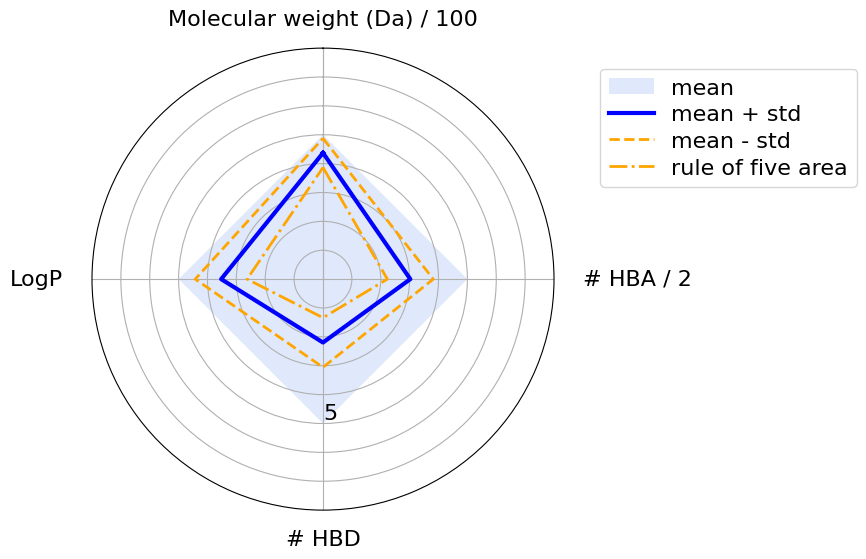

In [ ]:
plot_radar(
    molecules_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

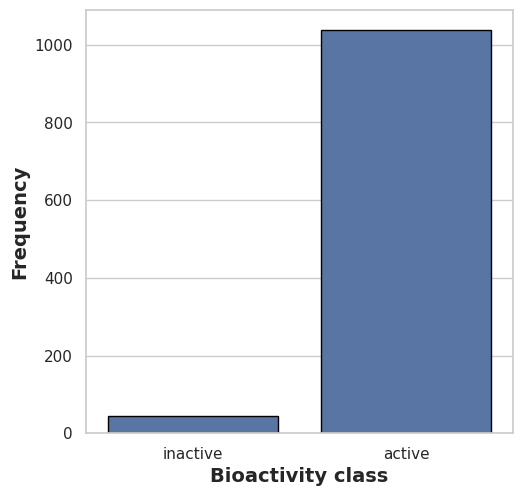

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=molecules, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.png', dpi=600, bbox_inches='tight')

<ipython-input-26-38c61e89ed24>:15: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(


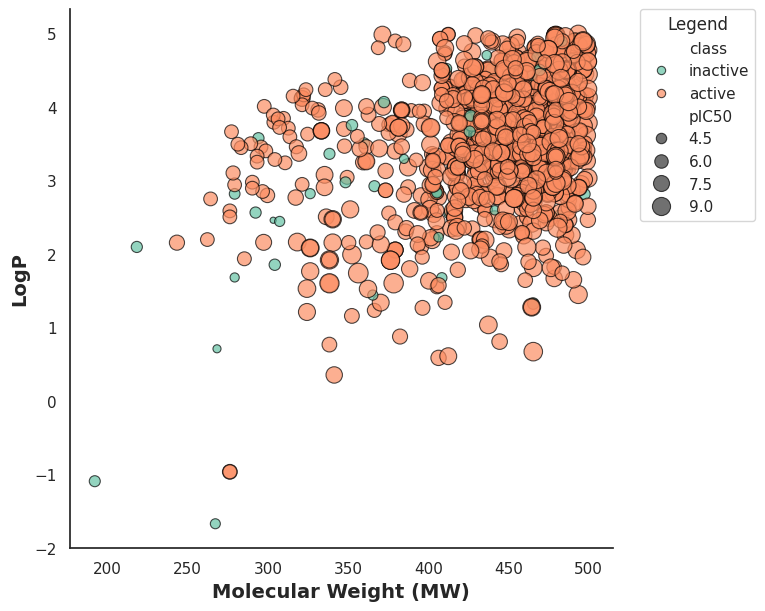

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

custom_palette = sns.color_palette("Set2")

plt.figure(figsize=(7, 7))

sns.scatterplot(
    x='molecular_weight',
    y='logp',
    data=molecules,
    hue='class',
    size='pIC50',
    sizes=(20, 200),
    palette=custom_palette,
    edgecolor='black',
    alpha=0.7
)

plt.xlabel('Molecular Weight (MW)', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Legend')
sns.despine()
plt.savefig('plot_MW_vs_LogP.png', dpi=600, bbox_inches='tight')
plt.show()


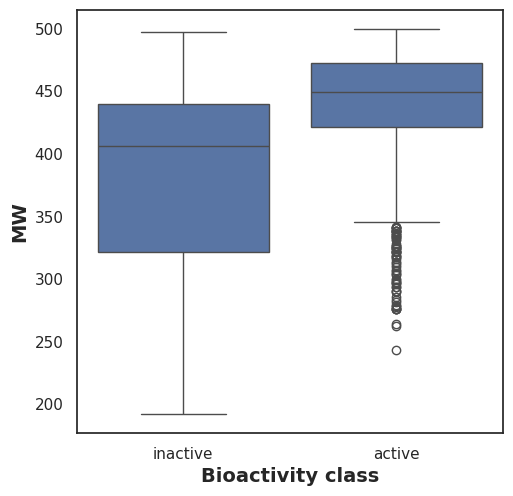

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'molecular_weight', data = molecules)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.png', dpi=600, bbox_inches='tight')

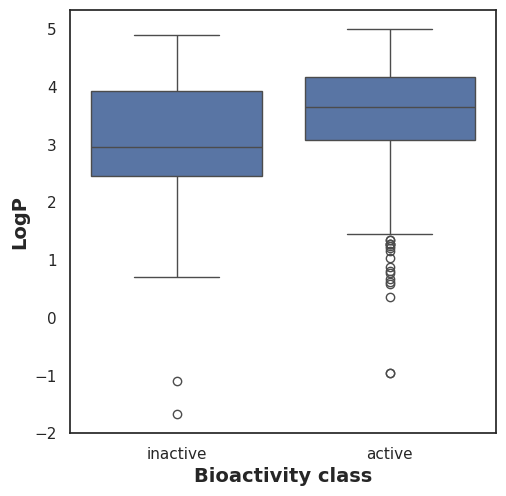

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'logp', data = molecules)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.png', dpi=600, bbox_inches='tight')

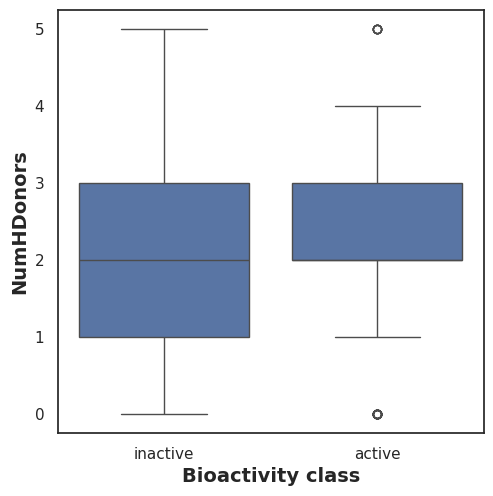

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'n_hbd', data = molecules)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.png', dpi=600, bbox_inches='tight')

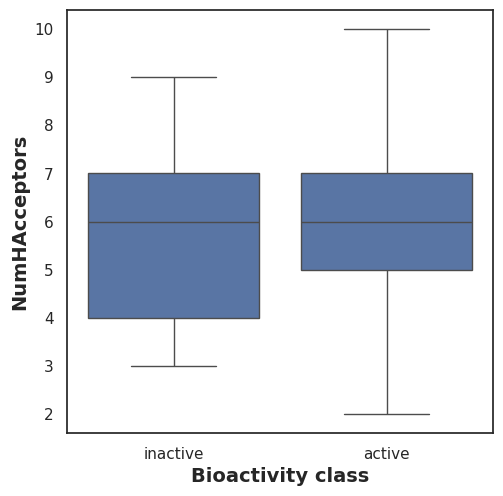

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'n_hba', data = molecules)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.png', dpi=600, bbox_inches='tight')

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: output_file_first_step.csv (deflated 81%)
